# Convolutional Neural Network (CNN) with PyTorch on [Flowers Recognition dataset](https://www.kaggle.com/alxmamaev/flowers-recognition)
By [Zahra Taheri](https://github.com/zata213), December 6, 2020

## The easiest way to download kaggle data in Google Colab
Reference: https://towardsdatascience.com/how-to-use-kaggle-datasets-in-google-colab-bca5e452a676
- **First steps:**
  - Go to account page on Kaggle to generate an API token. On the account page, scroll down to API section.
  - If there is a previously generated API token, we should expire it by clicking on “Expire API Token”. If not, we can directly generate a token clicking on “Create New API Token”.

- **Next steps:**

In [ ]:
#!pip install -q kaggle

!pip install -q git+https://github.com/Kaggle/kaggle-api.git --upgrade

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zahrataheri","key":"5c435c8d31e9c4c62327ef5ac8f60102"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

**Download the dataset from kaggle:**
Click the three dots next to "New notebook" button on the dataset page. Click "Copy API command" and simply paste that in your colab notebook and run it.


In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 94% 425M/450M [00:04<00:00, 66.0MB/s]
100% 450M/450M [00:04<00:00, 103MB/s] 


### Import libraries

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import time

import torch
import torch.nn as nn
import torch.nn.functional as F
#from tqdm.notebook import tqdm
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
from torch.autograd import Variable
from torchsummary import summary

np.random.seed(42)
torch.manual_seed(42)

## Loading Dataset

In [ ]:
if os.path.exists("/content/flowers/")==False:
  print("unzip files!")
  !unzip -q flowers-recognition.zip

unzip files!


In [ ]:
#Define path to the directory
 
data_directory="/content/flowers/"
print('Data directory: ', os.listdir(data_directory))

os.chdir(data_directory)
 
print(os.getcwd())

Data directory:  ['rose', 'daisy', 'sunflower', 'dandelion', 'flowers', 'tulip']
/content/flowers


## Preparation of the dataset

In [ ]:
transform = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder(data_directory,transform=transform)

print(len(dataset))

8646


In [ ]:
print(dataset.classes)

['daisy', 'dandelion', 'flowers', 'rose', 'sunflower', 'tulip']


In [ ]:
dataset[7000][0].shape

torch.Size([3, 128, 128])

In [ ]:
# Split dataset into train and test

indices = list(range(len(dataset)))
split = int(np.floor(0.2 * len(dataset)))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:],indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Building Convolutional Neural Network with PyTorch

In [ ]:
batch_size = 64

train_loader = DataLoader(dataset,batch_size=batch_size,sampler=train_sampler)
test_loader = DataLoader(dataset,batch_size=batch_size,sampler=test_sampler)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


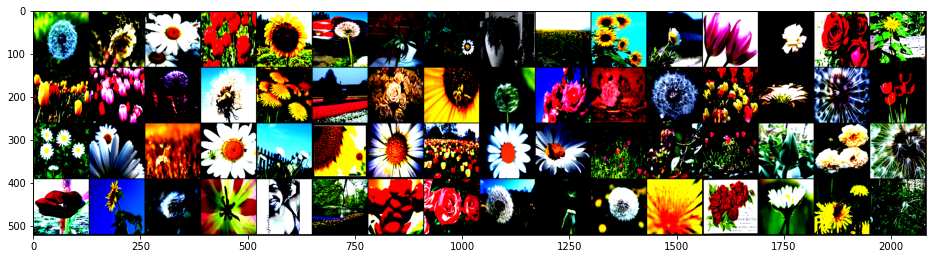

In [ ]:
from torchvision.utils import make_grid

for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(16,10))
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=2)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.cnn4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=2)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.4)

        # Fully connected 1 (readout)
        self.flatten = nn.Flatten() 
        self.fc = nn.Linear(256,6)
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.dropout2(out) 
        out = self.maxpool2(out)
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out) 
        out = self.cnn4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)     
        out = self.dropout1(out)     

        # Linear function (readout)
        out = self.flatten(out)
        out = self.fc(out)
        
        return out

In [ ]:
model = CNNModel()
model.to(device)

CNNModel(
  (cnn1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)

In [ ]:
summary(model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 65, 65]             896
              ReLU-2           [-1, 32, 65, 65]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 17, 17]          18,496
              ReLU-5           [-1, 64, 17, 17]               0
           Dropout-6           [-1, 64, 17, 17]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
            Conv2d-8            [-1, 128, 5, 5]          73,856
              ReLU-9            [-1, 128, 5, 5]               0
        MaxPool2d-10            [-1, 128, 2, 2]               0
           Conv2d-11            [-1, 256, 2, 2]         295,168
             ReLU-12            [-1, 256, 2, 2]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
          Dropout-14            [-1, 25

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adamax(model.parameters())

num_epochs = 20

In [ ]:
def compute_accuracy(net, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            outputs = net.forward(features)
            predicted_labels = torch.argmax(outputs, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100        
            
            

def compute_loss(net, data_loader):
    curr_loss = 0.
    with torch.no_grad():
        for cnt, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.to(device)
            outputs = net.forward(features)
            loss = criterion(outputs, targets)
            curr_loss += loss
        return float(curr_loss)/cnt 

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = Variable(features.to(device))
        targets = Variable(targets.to(device))
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/109 | Cost: 1.7826
Epoch: 001/020 Train Cost: 1.3916
Time elapsed: 0.70 min
Epoch: 002/020 | Batch 000/109 | Cost: 1.2819
Epoch: 002/020 Train Cost: 1.2965
Time elapsed: 1.41 min
Epoch: 003/020 | Batch 000/109 | Cost: 1.2769
Epoch: 003/020 Train Cost: 1.2655
Time elapsed: 2.12 min
Epoch: 004/020 | Batch 000/109 | Cost: 1.3089
Epoch: 004/020 Train Cost: 1.2478
Time elapsed: 2.82 min
Epoch: 005/020 | Batch 000/109 | Cost: 1.1869
Epoch: 005/020 Train Cost: 1.2180
Time elapsed: 3.52 min
Epoch: 006/020 | Batch 000/109 | Cost: 1.3150
Epoch: 006/020 Train Cost: 1.1863
Time elapsed: 4.23 min
Epoch: 007/020 | Batch 000/109 | Cost: 1.1661
Epoch: 007/020 Train Cost: 1.1450
Time elapsed: 4.93 min
Epoch: 008/020 | Batch 000/109 | Cost: 1.4015
Epoch: 008/020 Train Cost: 1.1284
Time elapsed: 5.63 min
Epoch: 009/020 | Batch 000/109 | Cost: 1.1782
Epoch: 009/020 Train Cost: 1.1157
Time elapsed: 6.34 min
Epoch: 010/020 | Batch 000/109 | Cost: 1.1471
Epoch: 010/020 Train Cost: 

In [ ]:
class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=2)
        self.BatchNorm1d1=nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=2)
        self.BatchNorm1d2=nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.cnn4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=2)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.4)

        # Fully connected 1 (readout)
        self.flatten = nn.Flatten() 
        self.fc = nn.Linear(256,6)
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.BatchNorm1d1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.dropout2(out) 
        out = self.maxpool2(out)
        out = self.cnn3(out)
        out = self.BatchNorm1d2(out)
        out = self.relu3(out)
        out = self.maxpool3(out) 
        out = self.cnn4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)     
        out = self.dropout1(out)     

        # Linear function (readout)
        out = self.flatten(out)
        out = self.fc(out)
        
        return out

In [ ]:
model = CNNModel2()
model.to(device)

CNNModel2(
  (cnn1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (BatchNorm1d1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (BatchNorm1d2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (relu4): ReLU()
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): 

In [ ]:
summary(model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 65, 65]             896
       BatchNorm2d-2           [-1, 32, 65, 65]              64
              ReLU-3           [-1, 32, 65, 65]               0
         MaxPool2d-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 17, 17]          18,496
              ReLU-6           [-1, 64, 17, 17]               0
           Dropout-7           [-1, 64, 17, 17]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9            [-1, 128, 5, 5]          73,856
      BatchNorm2d-10            [-1, 128, 5, 5]             256
             ReLU-11            [-1, 128, 5, 5]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Conv2d-13            [-1, 256, 2, 2]         295,168
             ReLU-14            [-1, 25

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters())

num_epochs = 20

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = Variable(features.to(device))
        targets = Variable(targets.to(device))
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/109 | Cost: 1.7619
Epoch: 001/020 Train Cost: 1.2811
Time elapsed: 0.70 min
Epoch: 002/020 | Batch 000/109 | Cost: 1.1623
Epoch: 002/020 Train Cost: 1.2165
Time elapsed: 1.41 min
Epoch: 003/020 | Batch 000/109 | Cost: 1.2099
Epoch: 003/020 Train Cost: 1.1928
Time elapsed: 2.11 min
Epoch: 004/020 | Batch 000/109 | Cost: 1.0611
Epoch: 004/020 Train Cost: 1.1411
Time elapsed: 2.82 min
Epoch: 005/020 | Batch 000/109 | Cost: 1.0343
Epoch: 005/020 Train Cost: 1.1280
Time elapsed: 3.52 min
Epoch: 006/020 | Batch 000/109 | Cost: 1.0621
Epoch: 006/020 Train Cost: 1.0690
Time elapsed: 4.22 min
Epoch: 007/020 | Batch 000/109 | Cost: 0.9538
Epoch: 007/020 Train Cost: 1.0495
Time elapsed: 4.92 min
Epoch: 008/020 | Batch 000/109 | Cost: 1.0041
Epoch: 008/020 Train Cost: 0.9766
Time elapsed: 5.62 min
Epoch: 009/020 | Batch 000/109 | Cost: 0.9590
Epoch: 009/020 Train Cost: 1.0090
Time elapsed: 6.32 min
Epoch: 010/020 | Batch 000/109 | Cost: 1.0050
Epoch: 010/020 Train Cost: 

In [ ]:
class CNNModel3(nn.Module):
    def __init__(self):
        super(CNNModel3, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1d1=nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.2)

        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1d2=nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout(0.3)

        
        self.cnn3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=2)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1d3=nn.BatchNorm2d(256)
        self.dropout3 = nn.Dropout(0.3)

        self.cnn4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=2)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        self.BatchNorm1d4=nn.BatchNorm2d(512)
        self.dropout4 = nn.Dropout(0.3)

        # Fully connected 1 (readout)
        self.flatten = nn.Flatten() 
        self.fc = nn.Linear(512,6)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.BatchNorm1d1(out)
        out = self.dropout1(out)
        out = self.cnn2(out)
        out = self.relu2(out) 
        out = self.maxpool2(out)
        out = self.BatchNorm1d2(out)
        out = self.dropout2(out)
        out = self.cnn3(out)
        out = self.relu3(out)
        out = self.maxpool3(out) 
        out = self.BatchNorm1d3(out)
        out = self.dropout3(out)
        out = self.cnn4(out)
        out = self.relu4(out)
        out = self.maxpool4(out)         
        out = self.BatchNorm1d4(out)
        out = self.dropout4(out)
        # Linear function (readout)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        return out

In [ ]:
model = CNNModel3()
model.to(device)

CNNModel3(
  (cnn1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BatchNorm1d1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (cnn2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BatchNorm1d2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (cnn3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (BatchNorm1d3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (cnn4): 

In [ ]:
summary(model, (3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 65, 65]           1,792
              ReLU-2           [-1, 64, 65, 65]               0
         MaxPool2d-3           [-1, 64, 32, 32]               0
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6          [-1, 128, 17, 17]          73,856
              ReLU-7          [-1, 128, 17, 17]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
       BatchNorm2d-9            [-1, 128, 8, 8]             256
          Dropout-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 5, 5]         295,168
             ReLU-12            [-1, 256, 5, 5]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
      BatchNorm2d-14            [-1, 25

In [ ]:
criterion = nn.CrossEntropyLoss()

learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters())

num_epochs = 20

In [ ]:
start_time = time.time()
minibatch_cost = []
epoch_cost = []
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = Variable(features.to(device))
        targets = Variable(targets.to(device))
            
        ### FORWARD AND BACK PROP
        outputs = model(features)
        
        cost = criterion(outputs, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 500:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
       
    model.eval()
    with torch.no_grad():
        cost = compute_loss(model, train_loader)
        epoch_cost.append(cost)
        print('Epoch: %03d/%03d Train Cost: %.4f' % (
                epoch+1, num_epochs, cost))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

        
model.eval()
with torch.no_grad():
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    print('Training Accuracy: %.2f' % compute_accuracy(model, train_loader))
    print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Epoch: 001/020 | Batch 000/109 | Cost: 2.0352
Epoch: 001/020 Train Cost: 1.6071
Time elapsed: 0.71 min
Epoch: 002/020 | Batch 000/109 | Cost: 1.7199
Epoch: 002/020 Train Cost: 1.6663
Time elapsed: 1.43 min
Epoch: 003/020 | Batch 000/109 | Cost: 1.7684
Epoch: 003/020 Train Cost: 1.6472
Time elapsed: 2.14 min
Epoch: 004/020 | Batch 000/109 | Cost: 1.7432
Epoch: 004/020 Train Cost: 1.5709
Time elapsed: 2.85 min
Epoch: 005/020 | Batch 000/109 | Cost: 1.6038
Epoch: 005/020 Train Cost: 1.5351
Time elapsed: 3.56 min
Epoch: 006/020 | Batch 000/109 | Cost: 1.6876
Epoch: 006/020 Train Cost: 1.5471
Time elapsed: 4.27 min
Epoch: 007/020 | Batch 000/109 | Cost: 1.5814
Epoch: 007/020 Train Cost: 1.5355
Time elapsed: 4.98 min
Epoch: 008/020 | Batch 000/109 | Cost: 1.5071
Epoch: 008/020 Train Cost: 1.5090
Time elapsed: 5.68 min
Epoch: 009/020 | Batch 000/109 | Cost: 1.3959
Epoch: 009/020 Train Cost: 1.5449
Time elapsed: 6.39 min
Epoch: 010/020 | Batch 000/109 | Cost: 1.5689
Epoch: 010/020 Train Cost: 